In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns; sns.set(style="ticks", color_codes=True)

In [2]:
GDP_pop = pd.read_csv('GDP_pop.csv', encoding='cp1251')
GDP_pop.head()

,CountryID,Country,GDP per capita (US dollars),Life expectancy (years)
0,4,Afghanistan,611.000,62.3
1,8,Albania,3.895,77.7
2,12,Algeria,4.163,75.3
3,24,Angola,4.171,60.2
4,28,Antigua and Barbuda,13.602,75.8


In [3]:
GDP_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 4 columns):
CountryID                      192 non-null int64
Country                        192 non-null object
GDP per capita (US dollars)    192 non-null float64
Life expectancy (years)        192 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 6.1+ KB


Тема работы: Исследование статистической связи между ВВП на душу населения и средней продолжительностью жизни. Будем брать для исследования данные за 2015 год, источник данных официальный сайт ООН. Данные предварительно очищены, удалены строки с неполными данными.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEB28843C8>,
      dtype=object)

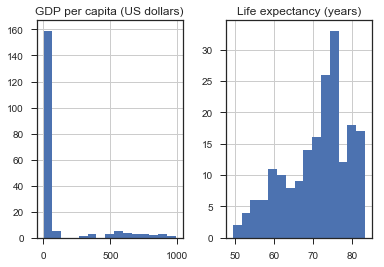

In [4]:
GDP_pop[['GDP per capita (US dollars)', 'Life expectancy (years)']].hist(bins=15)

Найдем коэффициент корреляции Пирсона:

In [5]:
GDP_pop[['GDP per capita (US dollars)', 'Life expectancy (years)']].corr()

,GDP per capita (US dollars),Life expectancy (years)
GDP per capita (US dollars),1.000000,-0.457272
Life expectancy (years),-0.457272,1.000000


Мы видим, что коэффициент корреляции имеет отрицательный знак, значит между величинами есть обратная корреляционная связь: увеличение одной величины сопровождается уменьшением другой.

In [36]:
GDP = np.array(GDP_pop['GDP per capita (US dollars)'])
pop = np.array(GDP_pop['Life expectancy (years)'])

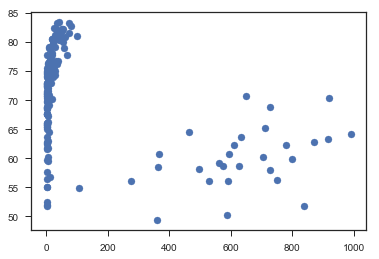

In [38]:
plt.scatter(GDP, pop)

Найдем коэффициенты линейной регрессии с помощью формул для парной регрессии:

In [39]:
b1 = (np.mean(GDP * pop) - np.mean(GDP) * np.mean(pop)) / (np.mean(GDP ** 2) - np.mean(GDP) ** 2)
b0 = np.mean(pop) - b1 * np.mean(GDP)
b1, b0

(-0.016048286695999715, 72.70033135628262)

Модель линейной регрессии будет иметь вид:
$$y = 72.7003 - 0.01605 \cdot x,$$

Text(0,0.5,'Средняя продолжительность жизни')

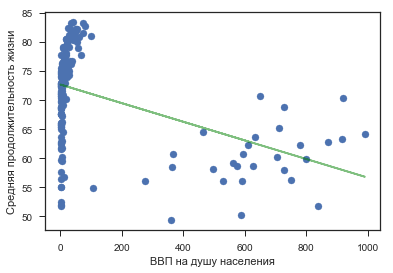

In [40]:
ox = GDP
oy = b0 + b1 * ox

plt.scatter(GDP, pop)
plt.plot(ox, oy, color='green', alpha=0.5)

plt.xlabel('ВВП на душу населения')
plt.ylabel('Средняя продолжительность жизни')

Создадим массив с предсказанными значениями основываясь на полученном уравнении линейной регрессии.

In [41]:
pop_pred = b0 + b1 * GDP

In [42]:
print(f'pop: {pop[:6]}')
print(f'pred: {pop_pred[:6]}')

pop: [62.3 77.7 75.3 60.2 75.8 71.6]
pred: [62.89482819 72.63782328 72.63352234 72.63339395 72.48204256 72.61176086]


Посчитаем коэффициент детерминаци.

In [11]:
R2 = np.corrcoef(GDP, pop) ** 2
R2

array([[1.        , 0.20909741],
       [0.20909741, 1.        ]])

In [12]:
R2 = R2[0][1]

Посчитаем среднюю ошибку аппроксимации:

In [13]:
A = np.abs((pop - pop_pred) / pop).mean()
A

0.08501336528981085

Приступим к оценке построенного уравнения регрессии с помощью $F$-критерия Фишера.

Для нашего примера имеем  $k1=1$ , $k2=192−2=190$. Посчитаем значение статистики  $T$ :

In [14]:
k1 = 1
k2 = 190

T1 = (R2 / (1 - R2)) * (k2 / k1)
T1

50.23186034526639

Теперь найдем критическое значение:

In [15]:
alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

3.8908674287894316

Мы получили $T>Fcrit$ , значит уравнение регрессии можно считать статистически значимым.

Приступим к оценке значимости получившихся параметров уравнения регрессии и построению для них доверительных интервалов с помощью $t$-статистики Стьюдента.

In [16]:
def standard_error_slope(
        x: np.ndarray,
        y: np.ndarray,
        z: np.ndarray,
) -> float:
    """Стандартная ошибка коэффициента наклона.
    """
    
    n = x.shape[0]
    
    upper = ((y - z) ** 2).sum() / (n - 2)
    lower = ((x - x.mean()) ** 2).sum()
    
    return np.sqrt(upper / lower)

In [17]:
s_slope = standard_error_slope(GDP, pop, pop_pred)
s_slope

0.002264326467019032

Зададим уровень значимости $\alpha = 0.05$. В нашем случае $n = 192$, т.к. это значение достаточно велико квантиль будем искать по соответствующей функции.

In [18]:
alpha = 0.05

t = stats.t.ppf(1 - alpha / 2, df=190)
t

1.9725281819983447

Тогда критическая область выглядит следующим образом:

$$\Omega_\alpha = \left( -\infty, - 1.9725 \right) \cup \left(1.9725, \infty \right).$$


$H_0$: $b_1 = 0$. Значение статистики $T$:

In [19]:
T = b1 / s_slope
T

-7.087443851295497

Значение попало в критическую область, значит, гипотеза о равенстве нулю параметра $b_1$ отвергается.

Доверительный интервал для параметра $b_1$:

In [20]:
(b1 - t * s_slope, b1 + t * s_slope)

(-0.02051473446543948, -0.011581838926559907)

Для параметра $b_0$:

In [21]:
s_intercept = s_slope * np.sqrt((GDP ** 2).mean())
s_intercept

0.5797741810601057

In [22]:
T = b0 / s_intercept
T

125.39422025201517

Значение попало в критическую область, значит, значение параметра $b_0$ является значимым.

Доверительный интервал для параметра $b_0$:

In [23]:
(b0 - t * s_intercept, b0 + t * s_intercept)

(71.55671044494655, 73.84395226761869)

$$y = 72.7003 - 0.01605 \cdot x,$$

К моему удивлению зависимость продолжительности жизни от ВВП на душу населения имеет обратный характер, т.е. увеличение ВВП влечет за собой уменьшение продолжительности жизни. Хотя если взять во внимание результаты анализа, то сама зависимость довольно мала. Коэффициент корреляции всего -0,45, довольно низкое значение. 